In [71]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, accuracy_score, roc_auc_score, mean_squared_error, confusion_matrix, r2_score
)

# !pip install catboost (catboost-1.2.7)
from catboost import CatBoostRegressor, CatBoostClassifier

from xgboost import XGBRegressor, XGBClassifier

from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingClassifier

from sklearn.neural_network import MLPClassifier

In [87]:
dataset = pd.read_pickle('../data/final/dataset_features.pkl')
target = 'est_un_accident_grave'

In [88]:
X_train, X_test, y_train, y_test = train_test_split(dataset.drop(target, axis=1), 
                                                    dataset[target], 
                                                    test_size=0.2, 
                                                    random_state=111)

In [83]:
def output_perf_clf(model):
    y_pred = model.predict(X_test)

    print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
    print(f'ROC AUC: {roc_auc_score(y_test, y_pred):.4f}')
    print(f'\n{classification_report(y_test, y_pred)}')
    print(f'Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}')

In [84]:
y_train.value_counts()

est_un_accident_grave
0    119547
1     11364
Name: count, dtype: int64

In [89]:
class_xgb = XGBClassifier()
class_xgb.fit(X_train, y_train)

output_perf_clf(class_xgb)

Accuracy: 0.9117
ROC AUC: 0.5057

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     29844
           1       0.46      0.01      0.02      2884

    accuracy                           0.91     32728
   macro avg       0.69      0.51      0.49     32728
weighted avg       0.87      0.91      0.87     32728

Confusion Matrix:
[[29801    43]
 [ 2847    37]]


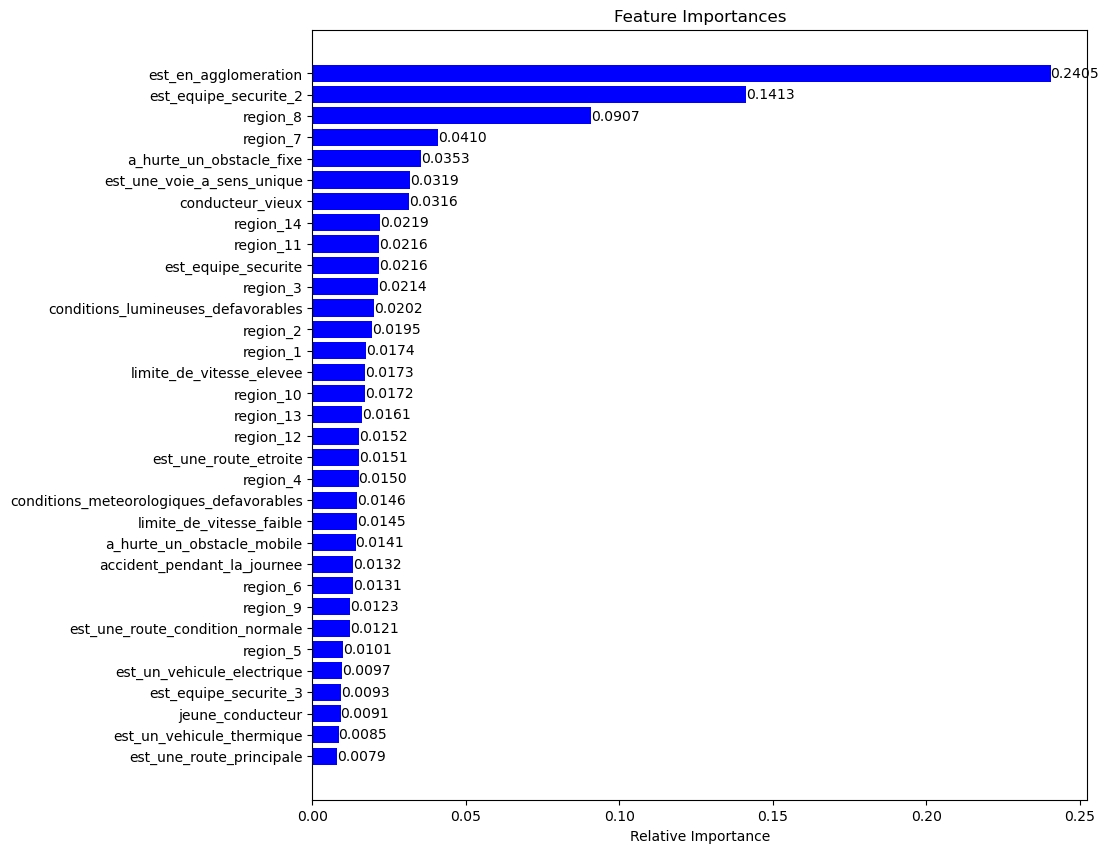

In [91]:
#display the features importance
fi = class_xgb.feature_importances_

features = X_train.columns

indices = np.argsort(fi)

import matplotlib.pyplot as plt29
plt.figure(figsize=(10, 10))
plt.title('Feature Importances')
bars = plt.barh(range(len(indices)), fi[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')

# Add values on the plot
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.4f}', va='center')

plt.show()

In [56]:
class_cat = CatBoostClassifier(verbose=0)
class_cat.fit(X_train, y_train)

output_perf_clf(class_cat)

Accuracy: 0.9186
ROC AUC: 0.5059

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     51259
           1       0.45      0.01      0.03      4528

    accuracy                           0.92     55787
   macro avg       0.68      0.51      0.49     55787
weighted avg       0.88      0.92      0.88     55787

Confusion Matrix:
[[51185    74]
 [ 4468    60]]


In [64]:
class_hist = HistGradientBoostingClassifier()
class_hist.fit(X_train, y_train)

output_perf_clf(class_hist)

Accuracy: 0.9190
ROC AUC: 0.5015

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     51259
           1       0.78      0.00      0.01      4528

    accuracy                           0.92     55787
   macro avg       0.85      0.50      0.48     55787
weighted avg       0.91      0.92      0.88     55787

Confusion Matrix:
[[51255     4]
 [ 4514    14]]


In [74]:
class_nn = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=100, verbose=True)
class_nn.fit(X_train, y_train)

output_perf_clf(class_nn)

Iteration 1, loss = 0.24745817
Iteration 2, loss = 0.23951702
Iteration 3, loss = 0.23812294
Iteration 4, loss = 0.23747712
Iteration 5, loss = 0.23649544
Iteration 6, loss = 0.23572972
Iteration 7, loss = 0.23521275
Iteration 8, loss = 0.23475374
Iteration 9, loss = 0.23398395
Iteration 10, loss = 0.23335531
Iteration 11, loss = 0.23265813
Iteration 12, loss = 0.23206114
Iteration 13, loss = 0.23144541
Iteration 14, loss = 0.23093484
Iteration 15, loss = 0.23010812
Iteration 16, loss = 0.22946095
Iteration 17, loss = 0.22882592
Iteration 18, loss = 0.22840327
Iteration 19, loss = 0.22758289
Iteration 20, loss = 0.22682848
Iteration 21, loss = 0.22636559
Iteration 22, loss = 0.22584074
Iteration 23, loss = 0.22532499
Iteration 24, loss = 0.22476105
Iteration 25, loss = 0.22410233
Iteration 26, loss = 0.22361922
Iteration 27, loss = 0.22302912
Iteration 28, loss = 0.22230473
Iteration 29, loss = 0.22189772
Iteration 30, loss = 0.22130865
Iteration 31, loss = 0.22094792
Iteration 32, los

h:\Documents\anaconda3\envs\cyu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.9089
ROC AUC: 0.5418

              precision    recall  f1-score   support

           0       0.93      0.98      0.95     51259
           1       0.31      0.10      0.16      4528

    accuracy                           0.91     55787
   macro avg       0.62      0.54      0.55     55787
weighted avg       0.88      0.91      0.89     55787

Confusion Matrix:
[[50238  1021]
 [ 4059   469]]


# OLD REGRESSION MODEL 'TOTAL COST OF ACCIDENT'

In [65]:
dataset_old = pd.read_parquet('../data/final/dataset_features.parquet')
target_old = 'total_cout_accident'

In [66]:
X_tr, X_te, y_tr, y_te = train_test_split(dataset_old.drop(target_old, axis=1), 
                                            dataset_old[target_old], 
                                            test_size=0.2, 
                                            random_state=111)

In [67]:
def output_perf_reg(model):
    y_pred = model.predict(X_te)

    mse = mean_squared_error(y_te, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_te, y_pred)

    print(f'Mean Squared Error (MSE): {mse:.4f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
    print(f'R-squared (R²): {r2:.4f}')

In [68]:
mod_hist = HistGradientBoostingRegressor(max_iter=10000, random_state=111)
mod_hist.fit(X_tr, y_tr)
#le modele se trompe de 3 points en moyenne
output_perf_reg(mod_hist)

Mean Squared Error (MSE): 7.4954
Root Mean Squared Error (RMSE): 2.7378
R-squared (R²): 0.4288


In [69]:
xgb = XGBRegressor(max_depth=10, n_estimators=800, random_state=111, min_child_weight=3, learning_rate=0.01) 
xgb.fit(X_tr, y_tr)

output_perf_reg(xgb)

Mean Squared Error (MSE): 7.5656
Root Mean Squared Error (RMSE): 2.7506
R-squared (R²): 0.4235


In [70]:
cat = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=10, random_state=111, verbose=0)
cat.fit(X_tr, y_tr)

output_perf_reg(cat)

Mean Squared Error (MSE): 7.6148
Root Mean Squared Error (RMSE): 2.7595
R-squared (R²): 0.4197


In [ ]:
nn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_transformed.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(y.unique()), activation='softmax')  # Nombre de classes = len(y.unique())
])
nn_model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
 
print("\n--- Réseau de Neurones ---")
nn_model.fit(X_train_transformed, y_train_encoded, epochs=20, batch_size=32, verbose=1)
 
# Évaluation du réseau de neurones
nn_loss, nn_accuracy = nn_model.evaluate(X_test_transformed, y_test_encoded, verbose=0)
y_pred_prob_nn = nn_model.predict(X_test_transformed)
nn_auc = roc_auc_score(y_test_encoded, y_pred_prob_nn, multi_class='ovr', average='weighted')
nn_rmse = np.sqrt(mean_squared_error(y_test_encoded, y_pred_prob_nn))
 
print("\nRésultats Réseau de Neurones:")
print(f"Accuracy: {nn_accuracy:.4f}")
print(f"AUC: {nn_auc:.4f}")
print(f"RMSE: {nn_rmse:.4f}")
 
# Résumé final des performances
print("\n--- Résumé des performances ---")
for model_name, metrics in results.items():
    print(f"{model_name}:")
    for metric, value in metrics.items():
        if metric == "Confusion Matrix":
            print(f"  {metric}:\n{value}")
        else:
            print(f"  {metric}: {value:.4f}" if value is not None else f"  {metric}: N/A")
print(f"Neural Network:")
print(f"  Accuracy: {nn_accuracy:.4f}")
print(f"  AUC: {nn_auc:.4f}")
print(f"  RMSE: {nn_rmse:.4f}")